In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
import healpy as hp
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from limstat.simulations import foregrounds

In [4]:
def plot_map(fg, map, ifreq=None):
    if ifreq is None:
        ifreq = fg.nfreqs//2
    plt.figure()
    im = plt.pcolor(fg.longitudes.to(units.deg).value.flatten(),
                    fg.latitudes.to(units.deg).value.flatten(),
                    map[:, :, ifreq],
                    shading='auto')
    plt.colorbar(label = r'$T$ [K]')
    plt.ylabel('Dec [deg]')
    plt.xlabel('RA [deg]')

## Parameters

In [5]:
# Simulation angular specs
ang_res = 150.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 200
#length and width of the box in Mpc
fov = ang_res.to(units.rad) * npix #rad

In [6]:
# Simulation spectral specs
nfreqs = 15
df = 100e3 * units.Hz
avg_nu = 150.e6 * units.Hz

spw_window = np.arange(avg_nu.value - df.value*nfreqs//2,
                       avg_nu.value + df.value*(nfreqs//2),
                       step=df.value) * units.Hz

print(f'{spw_window.size} frequency channels, '
      f'mean frequency {avg_nu.to(units.MHz):.1f}.')

15 frequency channels, mean frequency 150.0 MHz.


## Define a `foregrounds` object

Initialise the object with the following attributes:
* The frequencies along the considered spectral window, `freqs`. It must be an array with `astropy.units`.
* The number of pixels in the sky plane (for a square FoV: npix * npix).
* The angular resolution of the observation. Must be an `astropy.Quantity` with units.
* The location in the sky of the observation (centre of the FoV), given in terms of the right ascension (RA, in `units.deg`) and declination (Dec, in `units.deg`).
* If the model should include point sources (`point_sources=True`) or not and diffuse foregrounds (`diffuse=True`) or not, and if the latter should be evaluated with `pygdsm` (`use_pygdsm=True`).

In [8]:
fg = foregrounds(freqs=spw_window,
                 npix=npix,
                 ang_res=ang_res,
                 RA=0.*units.deg,
                 Dec=-30.*units.deg,
                 point_sources=True,
                 diffuse=True,
                 beam_area = 1.65e-03 * units.deg**2,
                 use_pygsm=True,)

Let's show the sky patch observed in a HEALpix map:

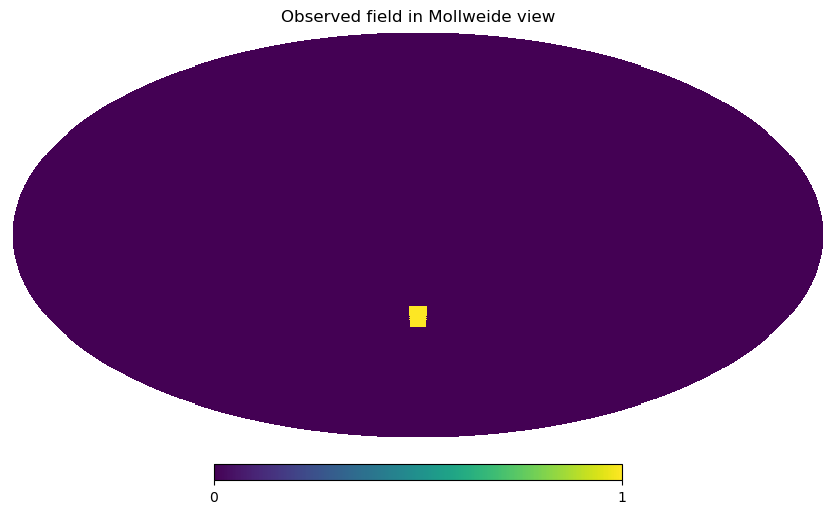

In [9]:
m = np.zeros(hp.nside2npix(1024))
obs_index = hp.pixelfunc.ang2pix(
    hp.get_nside(m),
    phi=fg.pixel_coordinates[1].to(units.deg).value, # phi = declination
    theta=fg.pixel_coordinates[0].to(units.deg).value, # theta = RA
    lonlat=True
    )
m[obs_index] = 1
hp.mollview(m, title="Observed field in Mollweide view")


## Diffuse foregrounds

The diffuse foregrounds model includes:
* Free-free emission, according to Liu et al., 2011
* Unresolved point sources emission, according to ?
* Galactic synchrotron emission, using either `pygdsm` or a spectral-index model from Liu et al., 2011

It can be computed separately from point sources:

In [10]:
diffuse_fg = fg.generate_diffuse()

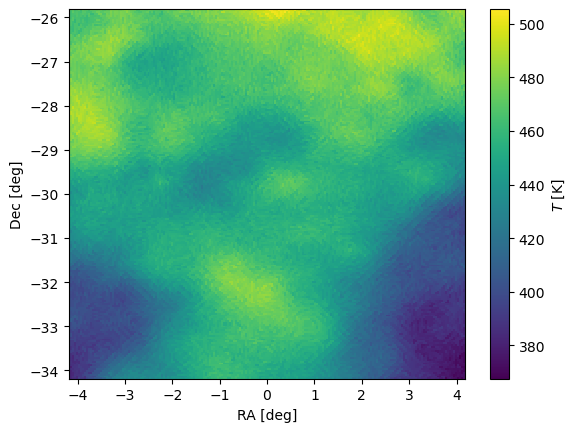

In [11]:
plot_map(fg, diffuse_fg)

You can also directly use `fg.generate_diffuse` and set the different inputs according to which signals you want to model:
* `synchrotron=True`,
* `free_free=True`,
* `unresolved_pt=True`.

Do not forget to parse the appropriate keys depending on which foregrounds you want to simulate (e.g. feed `ff_params` if `free_free` is `True`, see below.)

One can also generate the different elements of the diffuse foregrounds separately.

### Synchrotron emission

The synchrotron emission model can be generated with `pygdsm` or with a spectral-index model. If you choose the latter, you must feed the following model parameters as a list $[\alpha_0, \sigma_0, A_\mathrm{syn}]$:
* The distribution of spectral indices, defined as a Gaussian centred on $\alpha_0$ and with std $\sigma_0$
* The amplitude of the signal, $A_\mathrm{syn}$, in `units.K`.

Here is an example using the Global Sky Model 2016 from [Zheng et al., 2016](https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.3486Z/abstract).

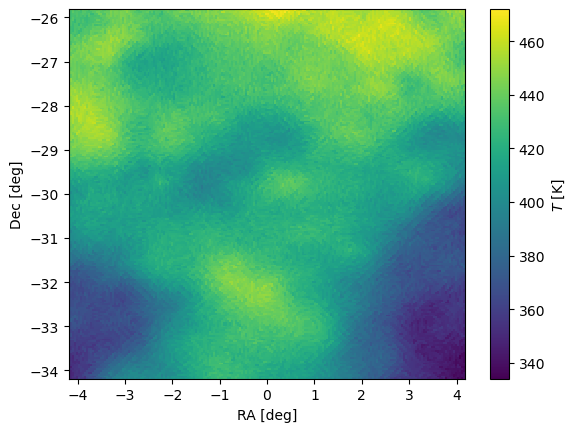

In [12]:
fg.use_pygsm = True
sync_map_pygsm = fg.generate_synchrotron()

plot_map(fg, sync_map_pygsm)

Here is an example using spectral indices:

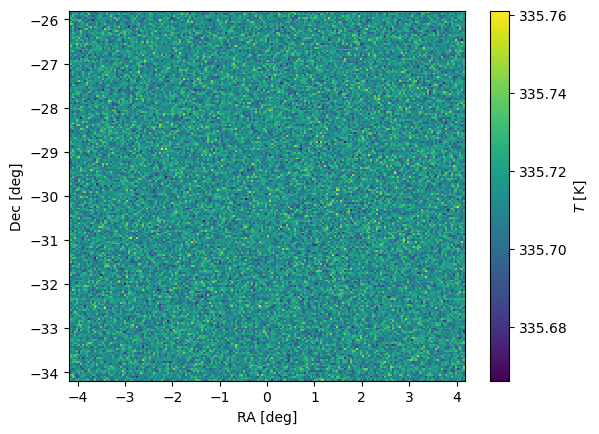

In [13]:
fg.use_pygsm = False
sync_map_power_law = fg.generate_synchrotron(sync_params=[2.8, 0.1, 335.4])

plot_map(fg, sync_map_power_law)

Note that `fg.generate_synchrotron` will choose whether or not to use `pygdsm` depending on the value of the `fg.use_pygsm` attribute.

In [14]:
fg.use_pygsm = True

### Free-free emission

To model the free-free emission, you must feed the following model parameters as a list $[\alpha_1, \sigma_1, A_\mathrm{free}]$:
* The distribution of spectral indices, defined as a Gaussian centred on $\alpha_1$ and with std $\sigma_1$
* The amplitude of the signal, $A_\mathrm{free}$, in `units.K`.

In [15]:
free_map = fg.generate_free_free(ff_params=[2.15, 0.01, 33.5])

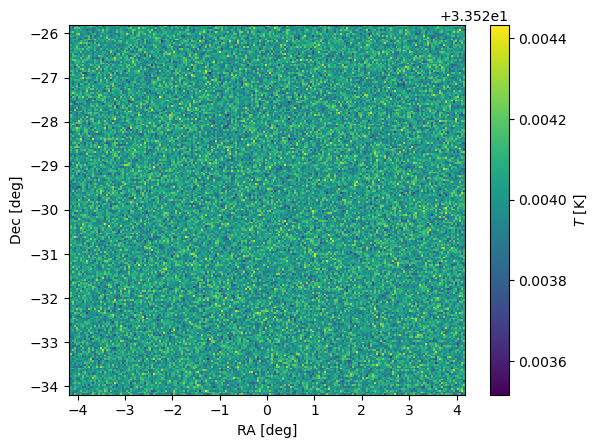

In [16]:
plot_map(fg, free_map)

### Unresolved point sources

I don't know what the model is :)

You can choose the total number of unresolved point sources in your field with the `n_upt` parameter.

In [18]:
upt_sources = fg.generate_unresolved_point_sources()

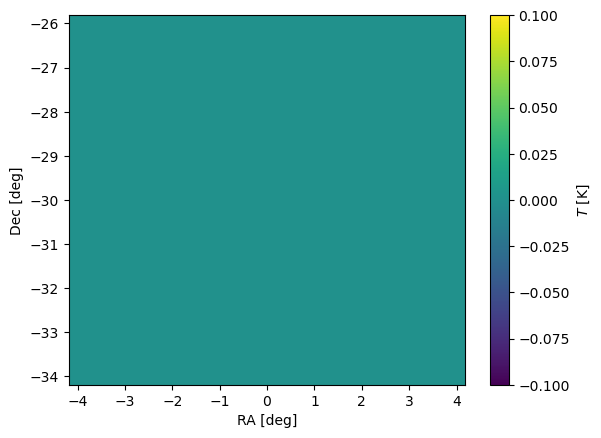

In [19]:
plot_map(fg, upt_sources)

## Point sources

To simulate the point sources in your field, simply use `fg.generate_point_sources` which will output a mock point sources catalog for your field. The parameters are:
* `n_src`, the number of point sources in your field.
* `min_flux`, the minimum flux of sources, in Jy (or equivalent unit).
* `max_flux`, the maximum flux of sources in Jy (or equivalent unit).

Note that the point sources are distributed randomly throughout the field and their flux is drawn from a log-normal distribution.

In [21]:
pt_map = fg.generate_point_sources(
            n_src=150,
            min_flux=0.1 * units.Jy,
            max_flux=100 * units.Jy,
            )

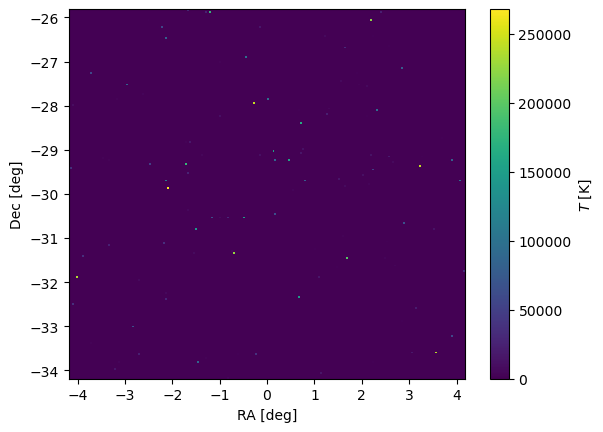

In [22]:
plot_map(fg, pt_map)

## Total foregrounds

The sum of all the above foregrounds can be directly generated with:

In [23]:
fg_lc = fg.generate_model(n_src=100, n_upt=200)

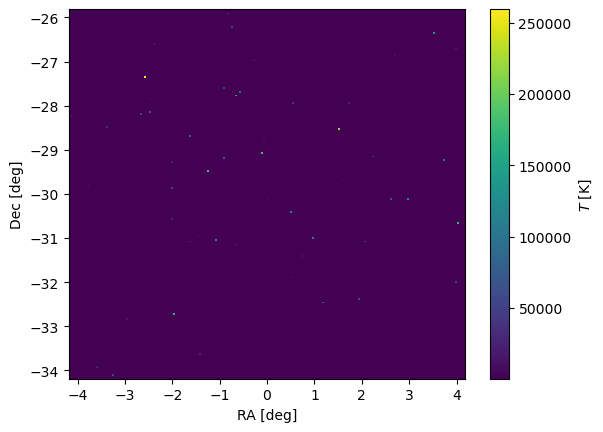

In [24]:
plot_map(fg, fg_lc)

Note that all foregrounds maps are given as an array with shape `(fg.npix, fg.npix, fg.nfreqs)` and units `units.K`.